# Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

# Описание колонок:
1. experimentVariant – вариант эксперимента

2. version – версия приложения

3. purchase – факт покупки

# Задача
1. Запустите A/A-тест.

2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.

3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения).

4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста.
 

💡 Ответ: как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

1. Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки

2. Посчитайте pvalue для каждой версии МП

3. Найдите версии, где pvalue < 0.05

4. Исключите версию с pvalue < 0.05 из основного датафрейма

5. Повторно запустите расчет FPR через A/A. Теперь FPR < альфа

Вы нашли поломку

In [83]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

In [44]:
df= pd.read_csv('hw_aa.csv', sep=';')

In [45]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.9+ MB


In [47]:
df.uid.nunique()

127018

In [104]:
df_retention=df.groupby(['experimentVariant','version'], as_index=False)\
               .agg({'purchase': lambda x: x.sum()/x.count()})\
               .rename(columns={'purchase':'conversion'})

In [106]:
df_retention

,experimentVariant,version,conversion
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


In [51]:
df.purchase.sum()/df.purchase.count()

0.03868743012801335

In [74]:
test=df.purchase.sample(n_s, replace = False).values

In [93]:
s1 = df.query('version!="v2.9.0" & experimentVariant==0').purchase.sample(n_s, replace = False).values
s2 = df.query('version!="v2.9.0" &experimentVariant==1').purchase.sample(n_s, replace = False).values
stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=-5.459903683252622, pvalue=5.6250725549318006e-08)

In [75]:
test.sum()/len(test)

0.04

  0%|          | 0/1000 [00:00<?, ?it/s]

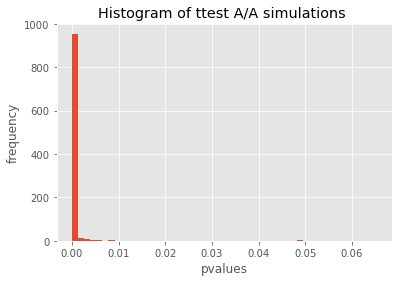

0.999

In [77]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('version!="v2.9.0" & experimentVariant==0').purchase.sample(n_s, replace = False).values
    s2 = df.query('version!="v2.9.0" &experimentVariant==1').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

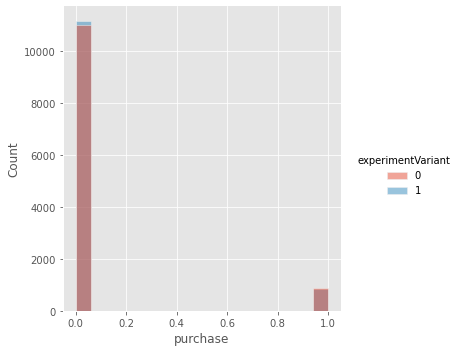

In [92]:
sns.displot(df.query('version=="v2.9.0"'), x='purchase', hue='experimentVariant')

array([[<AxesSubplot:title={'center':'experimentVariant'}>,
        <AxesSubplot:title={'center':'purchase'}>]], dtype=object)

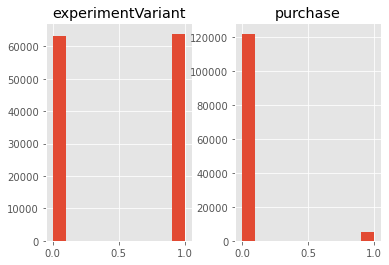

In [66]:
df.hist()

In [126]:
n = min([df.query('version=="v2.8.0" & experimentVariant==0').purchase.count(),
          df.query('version=="v2.8.0" & experimentVariant==1').purchase.count()])
s1 = df.query('version=="v2.8.0" & experimentVariant==0').purchase.sample(n, replace = False).values
s2 = df.query('version=="v2.8.0" &experimentVariant==1').purchase.sample(n, replace = False).values
print('p-value for v2.8.0: ',stats.ttest_ind(s1, s2, equal_var = False)[1])

n = min([df.query('version=="v2.9.0" & experimentVariant==0').purchase.count(),
          df.query('version=="v2.9.0" & experimentVariant==1').purchase.count()])
s1 = df.query('version=="v2.9.0" & experimentVariant==0').purchase.sample(n, replace = False).values
s2 = df.query('version=="v2.9.0" &experimentVariant==1').purchase.sample(n, replace = False).values
print('p-value for v2.9.0: ',stats.ttest_ind(s1, s2, equal_var = False)[1])

n = min([df.query('version=="v3.7.4.0" & experimentVariant==0').purchase.count(),
          df.query('version=="v3.7.4.0" & experimentVariant==1').purchase.count()])
s1 = df.query('version=="v3.7.4.0" & experimentVariant==0').purchase.sample(n, replace = False).values
s2 = df.query('version=="v3.7.4.0" &experimentVariant==1').purchase.sample(n, replace = False).values
print('p-value for v3.7.4.0: ',stats.ttest_ind(s1, s2, equal_var = False)[1])

n = min([df.query('version=="v3.8.0.0" & experimentVariant==0').purchase.count(),
          df.query('version=="v3.8.0.0" & experimentVariant==1').purchase.count()])
s1 = df.query('version=="v3.8.0.0" & experimentVariant==0').purchase.sample(n, replace = False).values
s2 = df.query('version=="v3.8.0.0" &experimentVariant==1').purchase.sample(n, replace = False).values
print('p-value for v3.8.0.0: ',stats.ttest_ind(s1, s2, equal_var = False)[1])

p-value for v2.8.0:  0.0
p-value for v2.9.0:  0.3443431331058745
p-value for v3.7.4.0:  0.5856223445462282
p-value for v3.8.0.0:  0.3231961609144097


In [125]:
n = min([df.query('version=="v2.9.0" & experimentVariant==0').purchase.count(),
          df.query('version=="v2.9.0" & experimentVariant==1').purchase.count()])
s1 = df.query('version=="v2.9.0" & experimentVariant==0').purchase.sample(n, replace = False).values
s2 = df.query('version=="v2.9.0" &experimentVariant==1').purchase.sample(n, replace = False).values
print('p-value for v2.9.0: ',stats.ttest_ind(s1, s2, equal_var = False)[1])

p-value for v2.9.0:  0.2954377847725959


In [118]:
n_s

21819

In [121]:
s1 = df.query('version!="v2.8.0" & experimentVariant==0').purchase.sample(n_s, replace = False).values
s2 = df.query('version!="v2.8.0" &experimentVariant==1').purchase.sample(n_s, replace = False).values
stats.ttest_ind(s1, s2, equal_var = False)[1]

0.8787281602079482

In [110]:
df.query('version!="v2.8.0" & experimentVariant==0').purchase.count()

21819

In [111]:
df.query('version!="v2.8.0" & experimentVariant==1').purchase.count()

22364